# Fundamentals of Data Science Final Project (DNN Approach)

---
Dog Breed Identification (Multi-class Identification through Neural Networks)

> Team members:
  1.   Mehrzad Jafari Ranjbar
  2.   Marco Muscas
  3.   Giovanni Giunta
  4.   Francesco Lauro
  5.   Shokoufeh Mansourihafshejani

<br>

We want to explore more in details a subject that we all have found particularly interesting during this course, which is <b>Computer Vision</b>. 
<br>
<br>
To do so, we intend to work on this Dog Breed Identification <a href="https://www.kaggle.com/c/dog-breed-identification/overview/"><img src="https://upload.wikimedia.org/wikipedia/commons/7/7c/Kaggle_logo.png" width="50" height="19"/></a>
competition that aims at implementing Image Classification models that are able to classify dogs of different breeds among over a 10k files dataset of pictures by using different libraries, techniques and approaches The goal of the project is to create classifiers that are able to determine dogs breeds from photos and perform a comparison among different models. <br>
<br>
<br>

We're going to go through the following Transfer Learning workflow: <br>

1. Importing the data.
2. Preparing the data.
3. Choose and fit/train a model ([TensorFlow Hub](https://www.tensorflow.org/hub), `tf.keras.applications`, [TensorBoard](https://www.tensorflow.org/tensorboard), [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)).
4. Evaluating a model
5. Improve the model through experimentation
6. Save, sharing and reloading your model

<b> In this notebook we skip EDA (Exploratory Data Analysis) as we have explained them in depth in previous notebook </b> [Click here](https://colab.research.google.com/drive/1cC3qFVOgQYRKLUeUL5WKtLO5WuUUjhPY?usp=sharing)

<br>
<br>

For preprocessing our data, we're going to use TensorFlow. The idea here is to get our data into Tensors (i.e. arrays of numbers which can be run on GPUs) and then allow a machine learning model to find patterns between them.


Importing TensorFlow

In [1]:
import tensorflow as tf

## Importing and Processing Input Data

### Importing the Data

Mounting Google Drive in this notebook and import the file.

In [2]:
# Importing Google Drive to Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We have unzipped the data already in the previous notebook.

Here we just access the data.

#### Accessing Data

In [3]:
# Checking the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Dog Breed Identification/labels.csv")
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


### Processing the Data
Since we've got the image ID's and their labels in a DataFrame (`labels_csv.csv`), we'll use it to create: <br>


<br>





**1.  A list a filepaths to training images**

In [4]:
# Create pathnames from image ID's
filenames = ["drive/My Drive/Dog Breed Identification/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10 filenames
filenames[:10]

['drive/My Drive/Dog Breed Identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Breed Identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Breed Identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Breed Identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Breed Identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Breed Identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Breed Identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Breed Identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Breed Identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Breed Identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']



**2.  An array of all labels:**



In [5]:
import numpy as np
labels = labels_csv["breed"].to_numpy() # convert labels column to NumPy array
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

Let's check if everything's set

In [6]:
import os
from tqdm import tqdm
if len(os.listdir("drive/My Drive/Dog Breed Identification/train/")) == len(filenames):
  if len(labels) == len(filenames):
    print("Matched!")
else:
  print("Not Matched")

Matched!


Great! We're good to continue



**3.  An array of all unique labels:**

In [7]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

Mapping each label string to an integer label

In [8]:
class_to_num = dict(zip(unique_breeds, range(120)))

### Preprocessing images

Our labels are in numeric format but our images are still just file paths.

First we create a custom function to create our independent variable (X) for us using `filenames` and setting the image sizes .

This is the same approach as [Linear Approach](https://colab.research.google.com/drive/1cC3qFVOgQYRKLUeUL5WKtLO5WuUUjhPY?usp=sharing) to preprocess the images.

<br>

**The main difference:** Here we set the image size to 331, since this size suits our functional approach for this notebook.

In [9]:
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import to_categorical

def preprocess_train(filenames, labels_csv, img_size = (224,224,3)):
    '''
    1- Read image samples from certain directory.
    2- Risize it, then stack them into one big numpy array.
    3- Read sample's label form the labels dataframe.
    4- One hot encode labels array.
    5- Shuffle Data and label arrays.
    '''

    images_labels = labels_csv['breed']
    data_size = len(labels_csv)
    #initailize output arrays.
    X = np.zeros([data_size, img_size[0], img_size[1], img_size[2]], dtype=np.uint8)
    y = np.zeros([data_size,1], dtype=np.uint8)
    #read data and lables.
    for i in tqdm(range(data_size)):
        img_dir = filenames[i]
        X[i] = load_img(img_dir, target_size=img_size)

        image_breed = images_labels[i]
        y[i] = class_to_num[image_breed]
    
    #One hot encoder
    y = to_categorical(y)
    #shuffle    
    ind = np.random.permutation(data_size)
    X = X[ind]
    y = y[ind]

    return X, y

In [10]:
# Setup X & y variables
X, y = preprocess_train(filenames, labels_csv, img_size = (331,331,3))

100%|██████████| 10222/10222 [00:42<00:00, 240.71it/s]


In [11]:
X[:2], y[:2]

(array([[[[  8,   6,   7],
          [  4,   4,   4],
          [  3,   3,   5],
          ...,
          [  8,  11,  56],
          [  7,  10,  55],
          [  5,   8,  53]],
 
         [[  7,   5,   6],
          [  4,   4,   4],
          [  2,   2,   4],
          ...,
          [  8,  11,  56],
          [  7,  10,  55],
          [  5,   8,  53]],
 
         [[  7,   5,   6],
          [  3,   3,   3],
          [  2,   2,   4],
          ...,
          [  8,  11,  56],
          [  7,  10,  55],
          [  5,   8,  53]],
 
         ...,
 
         [[129, 115,  80],
          [128, 114,  79],
          [131, 117,  82],
          ...,
          [ 91,  60,  16],
          [ 85,  54,  10],
          [ 87,  56,  12]],
 
         [[142, 127,  94],
          [138, 123,  90],
          [138, 123,  90],
          ...,
          [ 94,  65,  21],
          [ 88,  59,  15],
          [ 90,  61,  17]],
 
         [[141, 126,  95],
          [136, 121,  90],
          [135, 120,  89],
   

## Creating the model

### Necessary libraries

In [11]:
import cv2, random, time, shutil, csv
import matplotlib.image as mpimg
np.random.seed(42)
%matplotlib inline 

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input


In [12]:
def get_features(model_name, data_preprocessor, input_size, data):
    '''
    1- Create a feature extractor to extract features from the data.
    2- Returns the extracted features and the feature extractor.
    '''
    #Prepare pipeline.
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    #Extract feature.
    feature_maps = feature_extractor.predict(data, batch_size=64, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

### Adding layers (Functional Approach)

In [13]:
# Extract features using InceptionV3 as extractor.
from keras.applications.inception_v3 import InceptionV3, preprocess_input
img_size = (331,331,3)
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X)

160/160 [==============================] - 52s 265ms/step
Feature maps shape:  (10222, 2048)


In [14]:
# Extract features using Xception as extractor.
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 img_size, X)

160/160 [==============================] - 90s 552ms/step
Feature maps shape:  (10222, 2048)


In [15]:
# Extract features using NASNetLarge as extractor.
from keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features = get_features(NASNetLarge,
                               nasnet_preprocessor,
                               img_size, X)

160/160 [==============================] - 279s 2s/step
Feature maps shape:  (10222, 4032)


In [16]:
# Extract features using InceptionResNetV2 as extractor.
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size, X)

160/160 [==============================] - 120s 727ms/step
Feature maps shape:  (10222, 1536)


In [17]:
#X variable won't be needed anymore, so let's get rid of it.
del X

### Final features extraction

In [20]:
final_features = np.concatenate([inception_features,
                                 xception_features,
                                 nasnet_features,
                                 inc_resnet_features,], axis=-1)
print('Final feature maps shape', final_features.shape)

Final feature maps shape (10222, 9664)


### Early Stopping (Callback)

In [21]:
from keras.callbacks import EarlyStopping
#Prepare call backs
EarlyStop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
my_callback=[EarlyStop_callback]

## Training the model

In [22]:
classes = 120
#Prepare DNN model
model = keras.models.Sequential([
    InputLayer(final_features.shape[1:]),
    Dropout(0.7),
    Dense(units = classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 9664)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               1159800   
Total params: 1,159,800
Trainable params: 1,159,800
Non-trainable params: 0
_________________________________________________________________


In [24]:
#Train simple DNN on extracted features.
model.fit(final_features, y,
            batch_size=128,
            epochs=60,
            validation_split=0.1,
            callbacks=my_callback)

Epoch 1/60
72/72 [==============================] - 1s 10ms/step - loss: 2.0135 - accuracy: 0.6095 - val_loss: 0.1973 - val_accuracy: 0.9326
Epoch 2/60
72/72 [==============================] - 0s 5ms/step - loss: 0.1665 - accuracy: 0.9477 - val_loss: 0.1818 - val_accuracy: 0.9335
Epoch 3/60
72/72 [==============================] - 0s 5ms/step - loss: 0.1430 - accuracy: 0.9562 - val_loss: 0.1738 - val_accuracy: 0.9443
Epoch 4/60
72/72 [==============================] - 0s 5ms/step - loss: 0.1170 - accuracy: 0.9607 - val_loss: 0.1806 - val_accuracy: 0.9394
Epoch 5/60
72/72 [==============================] - 0s 5ms/step - loss: 0.0904 - accuracy: 0.9727 - val_loss: 0.1790 - val_accuracy: 0.9433
Epoch 6/60
72/72 [==============================] - 0s 5ms/step - loss: 0.0739 - accuracy: 0.9752 - val_loss: 0.1857 - val_accuracy: 0.9374
Epoch 7/60
72/72 [==============================] - 0s 5ms/step - loss: 0.0704 - accuracy: 0.9770 - val_loss: 0.1938 - val_accuracy: 0.9345
Epoch 8/60
72/72 [=

## Saving and Loading the model

In [13]:
import datetime
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("drive/My Drive/Dog Breed Identification/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [12]:
import tensorflow_hub as hub
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [32]:
# Save our model
save_model(model, suffix="DNN_FI")

Saving model to: drive/My Drive/Dog Breed Identification/models/20201227-14381609079910-DNN_FI.h5...


'drive/My Drive/Dog Breed Identification/models/20201227-14381609079910-DNN_FI.h5'

In [14]:
# Load our model trained on 1000 images
model_loaded = load_model('drive/My Drive/Dog Breed Identification/models/20201227-14381609079910-DNN_FI.h5')

Loading saved model from: drive/My Drive/Dog Breed Identification/models/20201227-14381609079910-DNN_FI.h5


## Prediction

In [25]:
def preprocessing_test(test_filenames, img_size = (331,331,3)):
    '''
    Do same as preprocessing_train but omit some unnecessary steps for test data.
    '''

    data_size = len(test_filenames)
    test_data = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)
    
    for i in tqdm(range(data_size)):
        img_dir = test_filenames[i]
        img_pix = tf.keras.preprocessing.image.load_img(img_dir, target_size=img_size)
        test_data[i] = img_pix
    return test_data



In [50]:
# Create pathnames for test images
test_dir = "/content/drive/MyDrive/Dog Breed Identification/test/"
test_filenames = [test_dir + fname for fname in os.listdir(test_dir)]
test_filenames[:5]

['/content/drive/MyDrive/Dog Breed Identification/test/e22db0abd7c039726b9683fc0a372204.jpg',
 '/content/drive/MyDrive/Dog Breed Identification/test/e752d87634c6177a748d655a55aeec89.jpg',
 '/content/drive/MyDrive/Dog Breed Identification/test/e46a2bfb7816324d171c4e07786abc59.jpg',
 '/content/drive/MyDrive/Dog Breed Identification/test/e4a8dfc6e219b20a0cbced41eaf6a435.jpg',
 '/content/drive/MyDrive/Dog Breed Identification/test/e6af47e8b6973c8f8d2b9fd5af94c54d.jpg']

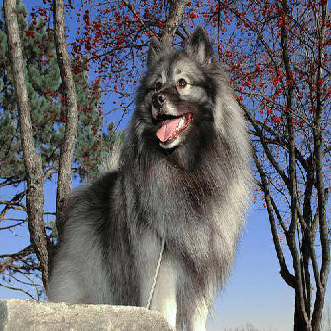

In [51]:
img_size = (331,331,3)
tf.keras.preprocessing.image.load_img(test_filenames[0], target_size=img_size)

In [52]:
test_data = preprocessing_test(test_filenames)

100%|██████████| 10357/10357 [34:34<00:00,  4.99it/s]


## Extracting

In [53]:
#Extract test data features.
inception_features = get_features(InceptionV3, inception_preprocessor, img_size, test_data)
xception_features = get_features(Xception, xception_preprocessor, img_size, test_data)
nasnet_features = get_features(NASNetLarge, nasnet_preprocessor, img_size, test_data)
inc_resnet_features = get_features(InceptionResNetV2, inc_resnet_preprocessor, img_size, test_data)

test_features = np.concatenate([inception_features,
                                 xception_features,
                                 nasnet_features,
                                 inc_resnet_features],axis=-1)
print('Final feature maps shape', test_features.shape)

162/162 [==============================] - 45s 273ms/step
Feature maps shape:  (10357, 2048)
162/162 [==============================] - 91s 561ms/step
Feature maps shape:  (10357, 2048)
162/162 [==============================] - 282s 2s/step
Feature maps shape:  (10357, 4032)
162/162 [==============================] - 121s 731ms/step
Feature maps shape:  (10357, 1536)
Final feature maps shape (10357, 9664)


In [58]:
#Free up some space.
del test_data

In [54]:
#Predict test labels given test data features.
y_pred = model.predict(test_features, batch_size=128)

In [57]:
#Create submission file
sample_df = pd.read_csv('drive/My Drive/Dog Breed Identification/sample_submission.csv')
for breed in unique_breeds:
    sample_df[breed] = y_pred[:,class_to_num[breed]]
sample_df.to_csv('drive/My Drive/Dog Breed Identification/full_submission_final_dnn_adam.csv', index=None)

## Prediction on Custom Images

In [43]:
# Get custom image filepaths
custom_path = "drive/My Drive/Dog Breed Identification/dogs/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]
custom_image_paths

['drive/My Drive/Dog Breed Identification/dogs/1.jpg',
 'drive/My Drive/Dog Breed Identification/dogs/2.jpg',
 'drive/My Drive/Dog Breed Identification/dogs/3.jpg',
 'drive/My Drive/Dog Breed Identification/dogs/6.jpg',
 'drive/My Drive/Dog Breed Identification/dogs/5.jpg',
 'drive/My Drive/Dog Breed Identification/dogs/4.jpg']

In [44]:
custom_data = preprocessing_test(custom_image_paths)

100%|██████████| 6/6 [00:00<00:00,  7.49it/s]


In [45]:
inception_features = get_features(InceptionV3, inception_preprocessor, img_size, custom_data)
xception_features = get_features(Xception, xception_preprocessor, img_size, custom_data)
nasnet_features = get_features(NASNetLarge, nasnet_preprocessor, img_size, custom_data)
inc_resnet_features = get_features(InceptionResNetV2, inc_resnet_preprocessor, img_size, custom_data)

custom_features = np.concatenate([inception_features,
                                 xception_features,
                                 nasnet_features,
                                 inc_resnet_features],axis=-1)
print('Final feature maps shape', custom_features.shape)

1/1 [==============================] - 2s 2s/step
Feature maps shape:  (6, 2048)
1/1 [==============================] - 1s 980ms/step
Feature maps shape:  (6, 2048)
1/1 [==============================] - 5s 5s/step
Feature maps shape:  (6, 4032)
1/1 [==============================] - 3s 3s/step
Feature maps shape:  (6, 1536)
Final feature maps shape (6, 9664)


In [46]:
# Make predictions on the features we have obtained on custom data
custom_preds = model.predict(custom_features)

In [31]:
# Turn prediction probabilities into their respective label
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]


In [47]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['eskimo_dog',
 'german_shepherd',
 'doberman',
 'chihuahua',
 'tibetan_terrier',
 'pug']

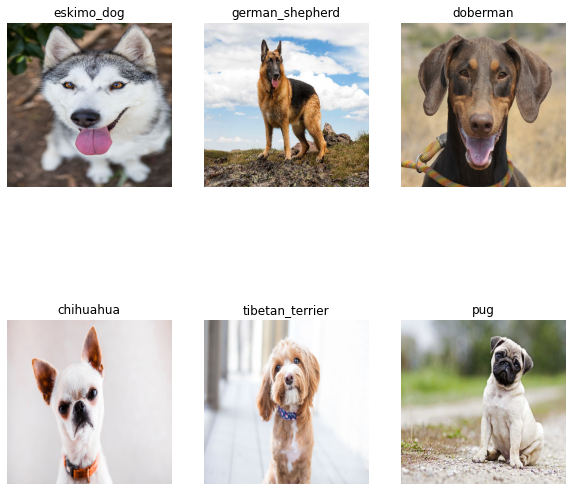

In [49]:
import matplotlib.pyplot as plt

# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_image_paths):
  plt.subplot(2, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(tf.keras.preprocessing.image.load_img(custom_image_paths[i], target_size=img_size))
  plt.axis("off")